In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.utils import tqdm
from src.plots import plot_histogram_with_percentile
from src.data_loading import iter_reviews
from src.data_loading import load_beers_breweries_users
from src.data_processing import add_review_columns
from src.plots import plot_histogram_with_percentile
from src.plots import plot_avg_overall_map
from src.data_processing import review_counts_by
from src.plot_wordcloud import plot_wordcloud, tf_idf
from src.data_loading import data_load_alternative
from src.models import emotion_sentiment
import scipy.stats as stats
import seaborn as sns
from src.models import polarity_sentiment
from src.text_processing import top_negative_words


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Data processing and analysis

### Data loading

In [3]:
data_path = "./data/BeerAdvocate/reviews.txt"
# printing 2 data samples as examples
for i, review in enumerate(iter_reviews(data_path, max_reviews=2, verbose=False)):
    print(review, end="\n\n")

{'beer_name': 'Régab', 'beer_id': '142544', 'brewery_name': 'Societe des Brasseries du Gabon (SOBRAGA)', 'brewery_id': '37262', 'style': 'Euro Pale Lager', 'abv': 4.5, 'date': 1440064800, 'user_name': 'nmann08', 'user_id': 'nmann08.184925', 'appearance': 3.25, 'aroma': 2.75, 'palate': 3.25, 'taste': 2.75, 'overall': 3.0, 'rating': 2.88, 'text': 'From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.'}

{'beer_name': 'Barelegs Brew', 'beer_id': '19590', 'brewery_name': 'Strangford Lough Brewing Company Ltd', 'brewery_id': '10093', 'style': 'English Pale Ale', 'abv': 4.5, 'date': 1235127600, 'user_name': 'StJamesGate', 'user_id': 'stjamesgate.163714', 'appearance': 3.0, 'aroma': 3.5, 'palate': 3.5, 'taste': 4.0, '

In [4]:
# BeerAdvocate
data_path = "./data/BeerAdvocate"
ba_beers, ba_breweries, ba_users = load_beers_breweries_users(data_path)
print("data shape of Beer Advocate dataset:")
print(ba_beers.shape, ba_breweries.shape, ba_users.shape)

# RateBeer
data_path = "./data/RateBeer"
rb_beers, rb_breweries, rb_users = load_beers_breweries_users(data_path)
print("data shape of Rate Beer dataset:")
print(rb_beers.shape, rb_breweries.shape, rb_users.shape)

data shape of Beer Advocate dataset:
(280823, 18) (16758, 4) (153704, 6)
data shape of Rate Beer dataset:
(442081, 17) (24189, 4) (70174, 5)


### Adding `review_count` and `avg_overall` columns for beers and users respectively

In this part, we add 1 new column based on review.txt to each of the beers and users dataesets. Note that we compute `avg_overall` using only the reviews (and not the ratings).

In [5]:
# BeerAdvocate
data_path = "./data/BeerAdvocate/reviews.txt"
ba_beers = add_review_columns(data_path, ba_beers, by="beer_id")
ba_users = add_review_columns(data_path, ba_users, by="user_id")
print(ba_beers.shape, ba_breweries.shape, ba_users.shape)

# RateBeer
data_path = "./data/RateBeer/reviews.txt"
rb_beers = add_review_columns(data_path, rb_beers, by="beer_id")
rb_users = add_review_columns(data_path, rb_users, by="user_id")
print(rb_beers.shape, rb_breweries.shape, rb_users.shape)

100%|█████████████████████████████████████████████████| 2589586/2589586 [00:14<00:00, 178601.16it/s]


(166649, 20) (16758, 4) (62252, 8)


100%|█████████████████████████████████████████████████| 7122074/7122074 [00:37<00:00, 192297.59it/s]


(396690, 19) (24189, 4) (70172, 7)


### Choosing RateBeer over BeerAdvocate

In this part, we analyse the data of both datasets and provide some reasons to choose RateBeer over BeerAdvocate.

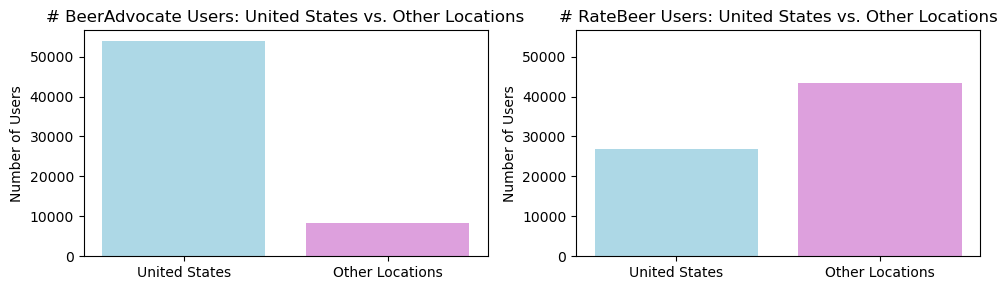

In [6]:
beeradvocate_us_users_count = ba_users['location'].str.contains('United States').sum()
ratebeer_us_users_count = rb_users['location'].str.contains('United States').sum()

beeradvocate_other_users_count = len(ba_users) - beeradvocate_us_users_count
ratebeer_other_users_count = len(rb_users) - ratebeer_us_users_count

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.bar(['United States', 'Other Locations'], [beeradvocate_us_users_count, beeradvocate_other_users_count], color=['lightblue', 'plum'])
plt.title('# BeerAdvocate Users: United States vs. Other Locations')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2, sharey=plt.gca()) # sharey to use same y axis range
plt.bar(['United States', 'Other Locations'], [ratebeer_us_users_count, ratebeer_other_users_count], color=['lightblue', 'plum'])
plt.title('# RateBeer Users: United States vs. Other Locations')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

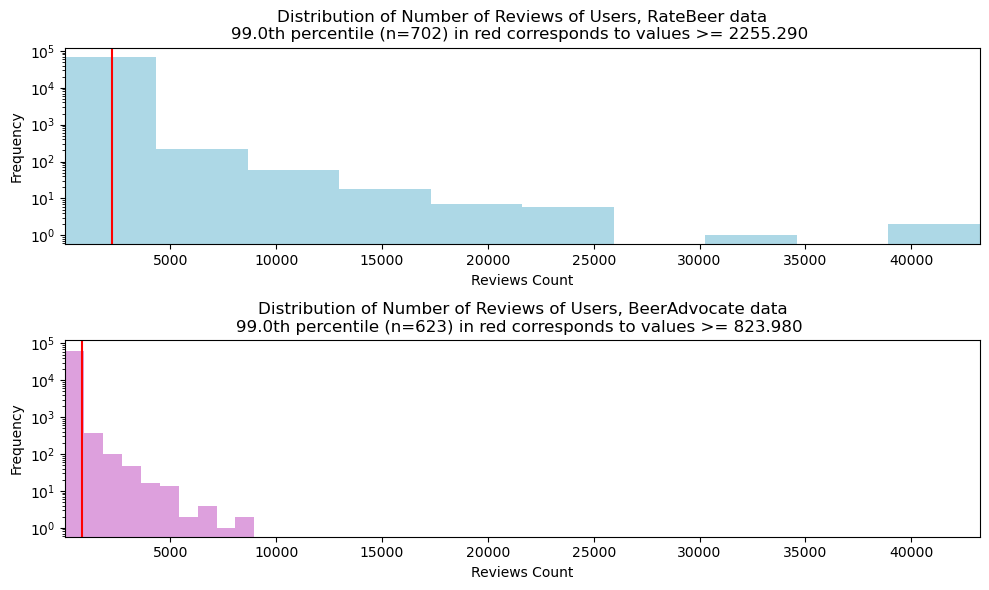

In [7]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plot_histogram_with_percentile(
    rb_users['review_count'], 'Distribution of Number of Reviews of Users, RateBeer data', q=99, color="lightblue")
plt.xlabel('Reviews Count')
plt.ylabel('Frequency')
plt.yscale('log')

plt.subplot(2, 1, 2, sharex=plt.gca(), sharey=plt.gca())
plot_histogram_with_percentile(
    ba_users['review_count'], 'Distribution of Number of Reviews of Users, BeerAdvocate data', q=99, color="plum")
plt.xlabel('Reviews Count')
plt.ylabel('Frequency')
plt.yscale('log')

plt.xlim((
    min(np.min(rb_users['review_count']), np.min(ba_users['review_count'])),
    max(np.max(rb_users['review_count']), np.max(ba_users['review_count']))
))

plt.tight_layout()
plt.show()

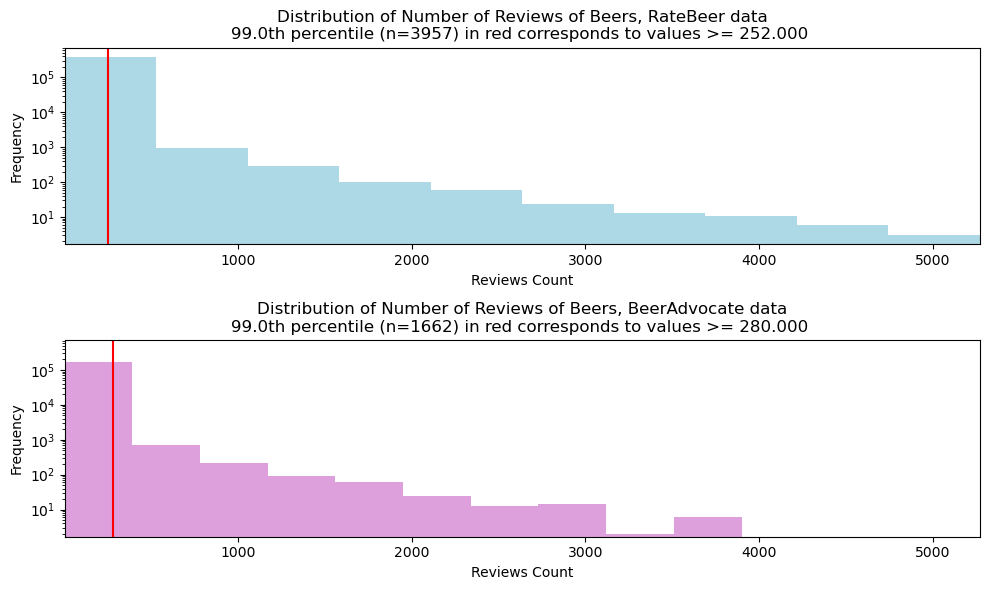

In [8]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plot_histogram_with_percentile(
    rb_beers['review_count'], 'Distribution of Number of Reviews of Beers, RateBeer data', q=99, color="lightblue")
plt.xlabel('Reviews Count')
plt.ylabel('Frequency')
plt.yscale('log')

plt.subplot(2, 1, 2, sharex=plt.gca(), sharey=plt.gca())
plot_histogram_with_percentile(
    ba_beers['review_count'], 'Distribution of Number of Reviews of Beers, BeerAdvocate data', q=99, color="plum")
plt.xlabel('Reviews Count')
plt.ylabel('Frequency')
plt.yscale('log')

plt.xlim((
    min(np.min(rb_beers['review_count']), np.min(ba_beers['review_count'])),
    max(np.max(rb_beers['review_count']), np.max(ba_beers['review_count']))
))

plt.tight_layout()
plt.show()

We choose RateBeer for 2 main reasons, visualized in the above plots :
- The user base for RateBeer is much more international and less focused on just the United States according to the first plot. In particular, we need this when we examine users by location in the following parts. While there are less users in RateBeer, they are much more active according to the 2nd plot, since there are more users with higher number of reviews in RateBeer data.
- RateBeer has 7M reviews, while BeerAdvocate has 2.5M (8.3M ratings, but we only care about reviews). Additionally, beers in the RateBeer dataset have more reviews on average according to the third plot. This matters because we will focus on beers with plenty of reviews.

Below we only work on RateBeer since that is the dataset we choose for the project.

### Cleaning the data

- User data : We drop users with duplicate user ids. The only missing values are locations and join dates, but we don't drop these users as the reviews they wrote are still valuable even if we won't be able to visualize their location for example.

- Beer data : There are no duplicate beer ids. We drop columns with too many missing values and those that are related to reviews, which we will recompute when needed using our data, as we don't know how these columns were computed and they don't always correspond to our data. Note that we keep abv (alchohol by volume) as it will be useful for later analysis.

- Brewery data : There are no duplicate ids and no missing values, so we don't do anything.

##### users dataset

In [9]:
duplicates_idx = rb_users.duplicated(subset='user_id', keep=False)
# save dropped users, so we can ignore their reviews later if needed
data_path = "./data/RateBeer/ignore_users.csv"
rb_users[duplicates_idx]["user_id"].to_csv(data_path)

In [10]:
#dropping dupliacte users in rb_users
rb_users = rb_users[~rb_users.duplicated(subset='user_id', keep=False)]
print("Cheking number of missing values in each columns of rb_users:")
rb_users.isnull().sum()

Cheking number of missing values in each columns of rb_users:


nbr_ratings         0
user_id             0
user_name           0
joined             30
location        19575
review_count        0
avg_overall         0
dtype: int64

##### beers dataset

In [11]:
print("number of duplicate beer ids in rb_beers:")
rb_beers[rb_beers.duplicated(subset='beer_id', keep=False)].shape[0]

number of duplicate beer ids in rb_beers:


0

In [12]:
print("number of missing values in each columns of rb_beers:")
rb_beers.isnull().sum()

number of missing values in each columns of rb_beers:


beer_id                           0
beer_name                         0
brewery_id                        0
style                             0
nbr_ratings                       0
overall_score                292662
style_score                  292622
avg                            1043
abv                           36732
avg_computed                      0
zscore                       354462
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    354462
id                                0
location                          0
name                              0
nbr_beers                         0
review_count                      0
avg_overall                       0
dtype: int64

In [13]:
drop_columns = [
    "overall_score", "style_score", "zscore", "nbr_matched_valid_ratings", "avg_matched_valid_ratings"
]
rb_beers = rb_beers.drop(columns=drop_columns)

##### breweries dataset

In [14]:
print("number of duplicate brewery ids in rb_breweries:")
rb_breweries[rb_breweries.duplicated(subset='id', keep=False)].shape[0]

number of duplicate brewery ids in rb_breweries:


0

In [15]:
print("number of missing values in each columns of rb_breweries:")
rb_breweries.isnull().sum()

number of missing values in each columns of rb_breweries:


id           0
location     0
name         0
nbr_beers    0
dtype: int64

### Cleaning and Analysis of text data

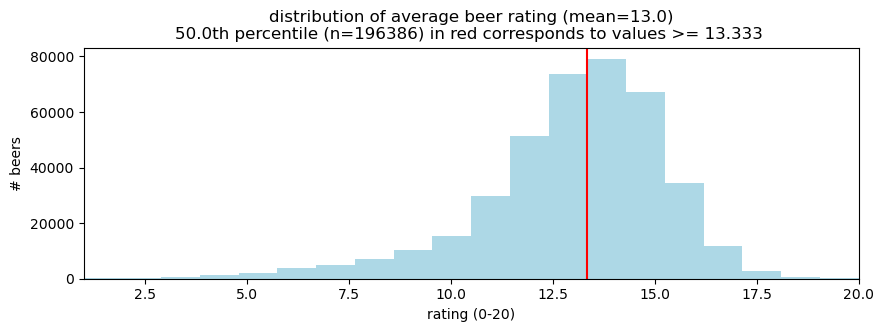

In [16]:
plt.figure(figsize=(10, 3))

plot_histogram_with_percentile(
    rb_beers["avg_overall"], f"distribution of average beer rating (mean={np.mean(rb_beers['avg_overall']):.1f})",
    q=50, bins=20, color="lightblue")

plt.xlabel("rating (0-20)")
plt.ylabel("# beers")

plt.xlim((np.min(rb_beers["avg_overall"]), np.max(rb_beers["avg_overall"])));

Looking at the `reviews.txt` file, there are 7'122'074 reviews. The `avg_overall` column of the beers dataframe corresponds to the average of the review's overall score for a beer. We then plot these average beer ratings in a histogram. The beer ratings are approximately normally distributed around the rating 13.0 (with a longer left tail), which means that they are quite varied but extreme values are rare which makes sense.

In [17]:
review_lengths = [len(review["text"].split()) for review in iter_reviews("./data/RateBeer/reviews.txt")]

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:48<00:00, 146188.90it/s]


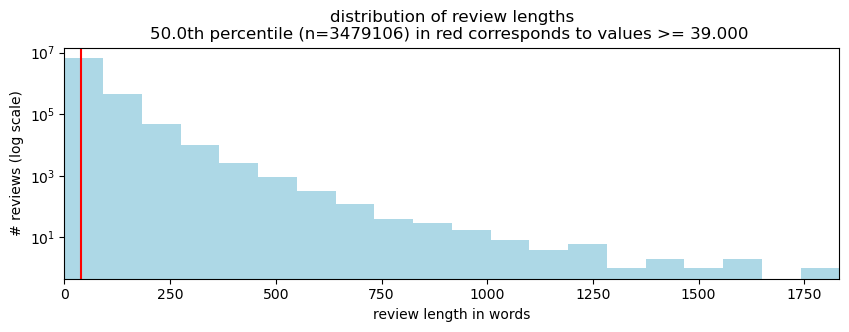

In [18]:
plt.figure(figsize=(10, 3))

plot_histogram_with_percentile(
    review_lengths, "distribution of review lengths",
    q=50, bins=20, color="lightblue")

plt.xlabel("review length in words")
plt.ylabel("# reviews (log scale)")
plt.yscale("log")

plt.xlim((np.min(review_lengths), np.max(review_lengths)));

Before analyzing the textual reviews, we need to make sure they are long enough, ie that they contain actual reviews of the beers and not just short reviews like "great beer!". In our case, the reviews are quite long and extensive, with a median word count of 39.

In [19]:
# missing data in text file
columns = (
    "beer_id", "brewery_id", "date", "abv", "appearance", "aroma", "palate",
    "taste", "overall", "rating", "text"
)
def encode_missing(review):
    encoded = [(1 if review[col] == "" else 0) for col in columns]
    return np.array(encoded)

data_path = "./data/RateBeer/reviews.txt"
n_reviews = len(review_counts_by(data_path, "text"))

raw_reviews = iter_reviews(data_path, max_reviews=n_reviews, do_cast=False)
missing_counts = sum(encode_missing(review) for review in raw_reviews)

for col, missing in zip(columns, missing_counts):
    print(f"{col} -> missing {missing} values")

100%|█████████████████████████████████████████████████| 7096057/7096057 [00:41<00:00, 169712.79it/s]

beer_id -> missing 0 values
brewery_id -> missing 0 values
date -> missing 0 values
abv -> missing 0 values
appearance -> missing 0 values
aroma -> missing 0 values
palate -> missing 0 values
taste -> missing 0 values
overall -> missing 0 values
rating -> missing 0 values
text -> missing 0 values


The reviews aren't missing any values, nothing to do here.

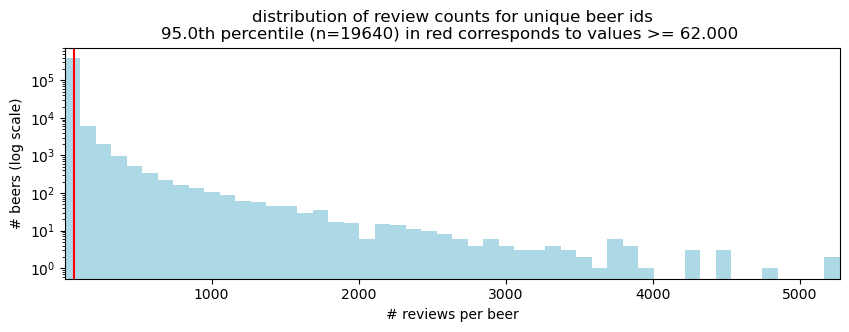

In [20]:
plt.figure(figsize=(10, 3))

plot_histogram_with_percentile(
    rb_beers["review_count"], "distribution of review counts for unique beer ids",
    q=95, bins=50, color="lightblue")

plt.xlabel("# reviews per beer")
plt.ylabel("# beers (log scale)")
plt.yscale("log")

plt.xlim((np.min(rb_beers["review_count"]), np.max(rb_beers["review_count"])));

To ensure that our results are statistically significant, we need to make sure that the beers we work on have enough reviews. We see here that this is the case, as selecting the top 5% of beers (20k) we get beers with at least 62 reviews, which is plenty to work with.

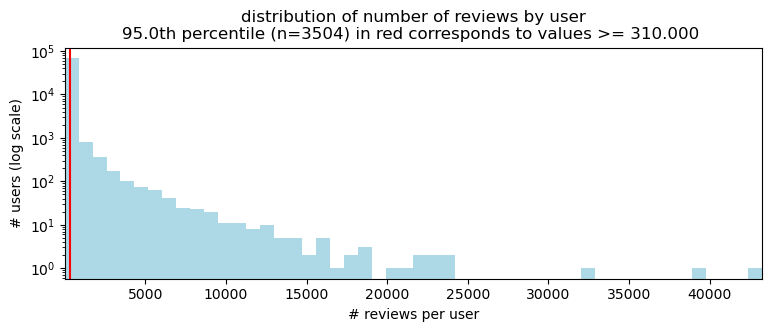

In [21]:
plt.figure(figsize=(9, 3))

plot_histogram_with_percentile(
    rb_users["review_count"], "distribution of number of reviews by user",
    q=95, bins=50, color="lightblue")

plt.xlabel("# reviews per user")
plt.ylabel("# users (log scale)")
plt.yscale("log")

plt.xlim((np.min(rb_users["review_count"]), np.max(rb_users["review_count"])));

In order to weight the contributions of reviewers, we plan to give "expert" status to a subset of users that have extensive experience in reviewing beers. As an example, we can see here that the top 5% of most active users have written 310 reviews at least, which is plenty to be called "expert". Note that we have yet to decide on a specific weighting strategy, and that we will likely change this threshold (top 5% of most active users) later, but this plot illustrates that this makes sense as a minority of users are very experienced and a majority not so much.

## Our Idea

People’s likes and preferences are usually the subject of much attention, but understanding what people actively hate can reveal deeper insights into user satisfaction and product improvement. In this project, we aim to extract the main criticisms of beer reviewers, focusing on the specific qualities and characteristics that generate dissatisfaction among reviewers.Additionally, we explore patterns in user behavior that indicate negativity beyond typical preferences, potentially identifying if factors like location or cultural expectations affect specific dislikes. We will augment our data with features extracted from textual reviews using text and emotion analysis.


## Basic pipeline

### Selecting beers with many reviews

In order to focus on the most popular beers, we first select the  beers with more than 99.9% of reviews in overall(top 0.1% of beers). This allows us to analyze the preferences of the most active reviewers, who are likely to have a more comprehensive understanding of the product. Also we wil be sure that there are enough reviews for each beer to make a meaningful analysis. We use 99.9% threshold for our basic pipeline and it may change in the future.

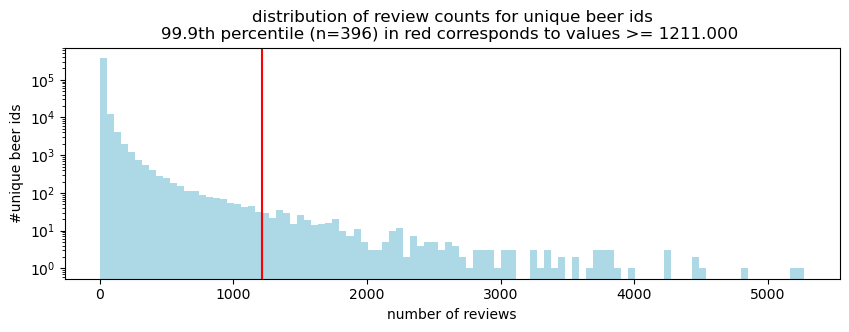

In [22]:
plt.figure(figsize=(10, 3))

threshold = plot_histogram_with_percentile(
    rb_beers["review_count"], "distribution of review counts for unique beer ids",
    q=99.9, bins=100, color="lightblue")
plt.xlabel("number of reviews")
plt.ylabel("#unique beer ids")
plt.yscale("log")

According to the histogram, the 99.9th percentile is 1211 reviews. We will select beers with more than 1211 reviews.

In [23]:
beer_with_min_count = list(rb_beers[rb_beers["review_count"] > threshold]["beer_id"])
print(f"number of beers with more than {threshold} reviews:")
print(len(beer_with_min_count))
print("total number of beers:")
print(len(rb_beers))

number of beers with more than 1211.0 reviews:
396
total number of beers:
396690


In [24]:
# finding all reviews for beers with more than 1211 reviews
beer_reviews = {}
data_path = "./data/RateBeer/reviews.txt"
for review in iter_reviews(data_path):
    beer_id = review["beer_id"]
    if beer_id in beer_with_min_count:
        beer_reviews.setdefault(beer_id, []).append(review)



100%|█████████████████████████████████████████████████| 7122074/7122074 [00:50<00:00, 140408.54it/s]


In [25]:
my_beer_id = next(iter(beer_reviews))
print("Some reviews for a specific popular beer:")
pd.DataFrame(beer_reviews[my_beer_id]).head(3)

Some reviews for a specific popular beer:


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Tiger Beer,3126,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Pale Lager,5.0,1500112800,lokis333,375455,3.0,6.0,4.0,7.0,12.0,3.2,Golden color with medium white foam. Aromas of...
1,Tiger Beer,3126,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Pale Lager,5.0,1500026400,sebsky,478504,3.0,2.0,2.0,3.0,6.0,1.6,"640 ml bottle @home,bb 31/05/2018.Golden,clear..."
2,Tiger Beer,3126,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Pale Lager,5.0,1499940000,Nevalainen,287835,3.0,4.0,3.0,4.0,7.0,2.1,Clear golden color with white head. Aroma of m...


### Task 1 : extracting beer features from reviews


In this part, first we try to extract some quantitive features from aggregated reviews of each beer such as average of rating in different aspects like arome, palate, etc. Then we will try to find some qualitative features from textual reviews of each beers.

In this way, we can compute the specific flavor profile and characteristics of each beer. This allows us to have richer descriptions for further analysis.


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

reviews_corpus = pd.DataFrame([
    (beer_id, "\n".join(r["text"] for r in beer_reviews[beer_id]))
    for beer_id in beer_reviews
], columns=["beer_id", "review_texts"])
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_corpus["review_texts"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

reviews_corpus["top_tfidf_word"] = tfidf_df.T.idxmax()

In [27]:
reviews_corpus.head(5)

,beer_id,review_texts,top_tfidf_word
0,3126,Golden color with medium white foam. Aromas of...,head
1,730,"640 ml bottle @home,bb 16/03/2018.Pale straw,c...",beer
2,224,One can only wonder what this beer would be li...,mexican
3,225,Common light beer very similiar to other Me I ...,mexican
4,230,Catpiss without real head. Aroma is straw ligh...,beer


In [38]:
REVIEW_COLUMNS = [
    'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'top_tfidf_word'
]

def aggregate_reviews(reviews):
    reviews = pd.DataFrame(reviews)
    beer_id = reviews["beer_id"][0]
    top_word = reviews_corpus[reviews_corpus["beer_id"] == beer_id]["top_tfidf_word"].iloc[0]
    return pd.concat([
        reviews[REVIEW_COLUMNS[:-1]].mean(),
        pd.Series([top_word], index=[REVIEW_COLUMNS[-1]])
    ])

aggregate_reviews(beer_reviews[my_beer_id])

appearance        2.579692
aroma             3.875964
palate            2.370823
taste             4.231362
overall           8.327763
rating             2.13856
top_tfidf_word        head
dtype: object

In [39]:
if set(REVIEW_COLUMNS) & set(rb_beers.columns) != set():
    raise ValueError("review columns contain names already in the dataset, we would be overwriting data")

aggregated_reviews = []

for beer_id in beer_reviews:
    reviews = beer_reviews[beer_id]
    aggregated_data = aggregate_reviews(reviews)
    aggregated_data["beer_id"] = beer_id  # add the beer_id to match on
    aggregated_reviews.append(aggregated_data)

aggregated_reviews_df = pd.DataFrame(aggregated_reviews)

rb_beers_aggregated = rb_beers.merge(aggregated_reviews_df, on="beer_id", how="inner")
print("aggregated data of different reviews for each bear:")
rb_beers_aggregated.head()

aggregated data of different reviews for each bear:


,beer_id,beer_name,brewery_id,style,nbr_ratings,avg,abv,avg_computed,id,location,...,nbr_beers,review_count,avg_overall,appearance,aroma,palate,taste,overall,rating,top_tfidf_word
0,3126,Tiger Beer,547,Pale Lager,1556,2.13,5.0,2.138560,547,Singapore,...,17,1556,8.327763,2.579692,3.875964,2.370823,4.231362,8.327763,2.138560,head
1,730,Tsingtao,116,Pale Lager,2031,2.03,4.8,2.045790,116,China,...,54,2031,7.940423,2.397834,3.712949,2.329394,4.077302,7.940423,2.045790,beer
2,224,Dos Equis XX Ambar (Amber),46,Amber Lager/Vienna,1741,2.45,4.7,2.469500,46,Mexico,...,46,1741,9.771396,3.049971,4.332567,2.647904,4.893165,9.771396,2.469500,mexican
3,225,Dos Equis XX Special Lager,46,Pale Lager,1518,2.08,4.2,2.098221,46,Mexico,...,46,1518,8.201581,2.519763,3.681818,2.391304,4.187747,8.201581,2.098221,mexican
4,230,Sol (Mexico),46,Pale Lager,1241,1.68,4.5,1.705721,46,Mexico,...,46,1241,6.413376,2.228042,3.019339,2.041096,3.355359,6.413376,1.705721,beer


Above table shows our quantitive analysis of the beer according to its reviews. These charactesristics can be used in the next milestone.

 Now we need to do a qualitative analysis of the reviews. We will do this by using a tf-idf method and wordcloud for visuallization.

In [40]:
# considering both 1grams and 2grams
beer_reviews_1 = pd.DataFrame(beer_reviews[my_beer_id])["text"].values
tfidf_table = tf_idf(beer_reviews_1, ngrams=(1, 2))
print(f"beer id = {my_beer_id}")
tfidf_table.head(15)


beer id = 3126


,Word,TF
13563,light,40.469493
22893,taste,36.742534
10886,head,36.261784
943,aroma,34.437103
16523,not,33.949474
1968,beer,33.805341
12823,lager,33.119662
17564,pale,31.694162
14508,malt,31.484298
3296,bottle,31.263894


In [41]:
# considering only bigrams
beer_reviews_1 = pd.DataFrame(beer_reviews[my_beer_id])["text"].values
tfidf_table = tf_idf(beer_reviews_1, ngrams=(2, 2))
print(f"beer id = {my_beer_id}")
tfidf_table.head(10)


beer id = 3126


,Word,TF
20806,white head,32.392713
9051,head aroma,17.391880
14604,pale lager,15.577333
13792,not much,13.852510
11235,light body,13.161503
14629,pale yellow,13.060036
13695,not bad,12.397874
15121,pour clear,12.318193
4230,clear golden,12.188064
14599,pale golden,11.013488


In above tables, we can see some frequent features for a specific beer that is extracted from reviews of that beer. We can use these features to compute a flavor profile for each beer

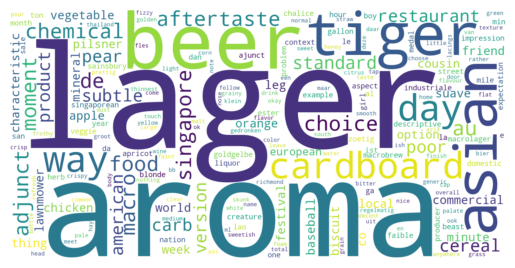

In [42]:
plot_wordcloud(beer_reviews_1)

above plot is a visuallization of the most frequent words in the reviews of the beer with id 3126.

With the aid of tf-idf, wordcloud and more preprocessing of the texts, we can extract more meaningful features for each beer in the next phase. Also we will weight different reviews based on its users, ie reviews of experts will have more weight than the reviews of normal users. we will find experts by taking into account the number of reviews and the number of beers they have rated.

### Task 2 : Choosing the negative reviews

In this part, we will use different methods to choose the negative reviews and texts that we will use for the next phase.

we test fillowing methods:
1. we choose the reviews with the lowest rating
2. We apply an emotion analysis on the reviews to find the negative reviews
3. We use a sentiment analysis to find the negative reviews based on the polaritzy of the review

First, we will choose a threshold for the rating, and use it to define negative reviews.

In [43]:
all_ratings = [review["rating"] for review in iter_reviews("./data/RateBeer/reviews.txt")]

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:36<00:00, 194552.91it/s]


(0.0, 5.0)

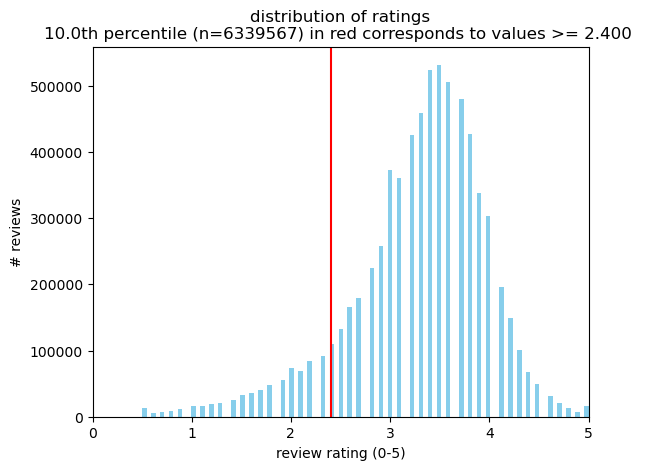

In [44]:
ratings_percentile = plot_histogram_with_percentile(all_ratings, "distribution of ratings", q=10, bins=100, color = "skyblue")
plt.xlabel("review rating (0-5)")
plt.ylabel("# reviews")
plt.xlim((0, 5))

according to the hidtogram, we can use 10th percentile to define a threshold for the ratings. 6339567 reviews are below this threshold which is quite enough to have reliable results. For this milestone, we will use 2.4 as the threshold for the ratings but it can be changed in the future.

In [45]:
# we will use 2.4 as the threshold for the ratings and find negative reviews for popular beers
min_reviews = 10
best_beer_reviews, worst_beer_reviews = {}, {}

for beer_id in beer_reviews:
    best_reviews, worst_reviews = [], []

    for review in beer_reviews[beer_id]:
        rating = review["rating"]

        if rating <= ratings_percentile:
            worst_reviews.append(review["text"])
        else:
            best_reviews.append(review["text"])

    if len(worst_reviews) > min_reviews and len(best_reviews) > min_reviews:
        best_beer_reviews[beer_id] = best_reviews
        worst_beer_reviews[beer_id] = worst_reviews

print("below you can see changes in number of reviews for some popular beers:\n")
for i, beer_id in enumerate(worst_beer_reviews):
    print(f" beer with beer id = {beer_id} went from {len(beer_reviews[beer_id])} total reviews to",
          f"{len(worst_beer_reviews[beer_id])} negative reviews")
    if i - 1 >= 10:
        break

below you can see changes in number of reviews for some popular beers:

 beer with beer id = 3126 went from 1556 total reviews to 1132 negative reviews
 beer with beer id = 730 went from 2031 total reviews to 1567 negative reviews
 beer with beer id = 224 went from 1741 total reviews to 857 negative reviews
 beer with beer id = 225 went from 1518 total reviews to 1108 negative reviews
 beer with beer id = 230 went from 1241 total reviews to 1084 negative reviews
 beer with beer id = 226 went from 1250 total reviews to 1067 negative reviews
 beer with beer id = 742 went from 3650 total reviews to 3038 negative reviews
 beer with beer id = 744 went from 1311 total reviews to 1018 negative reviews
 beer with beer id = 745 went from 2246 total reviews to 646 negative reviews
 beer with beer id = 746 went from 1382 total reviews to 1021 negative reviews
 beer with beer id = 237 went from 1403 total reviews to 1041 negative reviews
 beer with beer id = 8820 went from 1650 total reviews to 65

In [46]:
reviews_count_data = pd.DataFrame(
    [(beer_id, len(beer_reviews[beer_id]), len(worst_beer_reviews[beer_id])) for beer_id in worst_beer_reviews],
    columns=["beer_id", "total_reviews", "bad_reviews"]
)

rb_beers_agg_merged = rb_beers_aggregated.merge(reviews_count_data, on="beer_id", how="inner")
rb_beers_agg_merged.head(5)

,beer_id,beer_name,brewery_id,style,nbr_ratings,avg,abv,avg_computed,id,location,...,avg_overall,appearance,aroma,palate,taste,overall,rating,top_tfidf_word,total_reviews,bad_reviews
0,3126,Tiger Beer,547,Pale Lager,1556,2.13,5.0,2.138560,547,Singapore,...,8.327763,2.579692,3.875964,2.370823,4.231362,8.327763,2.138560,head,1556,1132
1,730,Tsingtao,116,Pale Lager,2031,2.03,4.8,2.045790,116,China,...,7.940423,2.397834,3.712949,2.329394,4.077302,7.940423,2.045790,beer,2031,1567
2,224,Dos Equis XX Ambar (Amber),46,Amber Lager/Vienna,1741,2.45,4.7,2.469500,46,Mexico,...,9.771396,3.049971,4.332567,2.647904,4.893165,9.771396,2.469500,mexican,1741,857
3,225,Dos Equis XX Special Lager,46,Pale Lager,1518,2.08,4.2,2.098221,46,Mexico,...,8.201581,2.519763,3.681818,2.391304,4.187747,8.201581,2.098221,mexican,1518,1108
4,230,Sol (Mexico),46,Pale Lager,1241,1.68,4.5,1.705721,46,Mexico,...,6.413376,2.228042,3.019339,2.041096,3.355359,6.413376,1.705721,beer,1241,1084


Now we will run some emotion analysis on the reviews and see if there are any correlations between the emotions and the ratings. If yes, we can use emotion analysis to find nagative reviews and complaints in the texts. our nlp model is "j-hartmann/emotion-english-distilroberta-base" from huggingface, and we will use "anger", "disgust", 'fear', 'joy', 'neutral', 'sadness', 'surprise' scores in its output

In [215]:
nb_reviews = 5882 # about 100K lines 
data_path = "data/RateBeer/reviews.txt"
beer_reviews_emotion = data_load_alternative(data_path, nb_reviews)

In [221]:
emotion_data = emotion_sentiment(beer_reviews_emotion)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


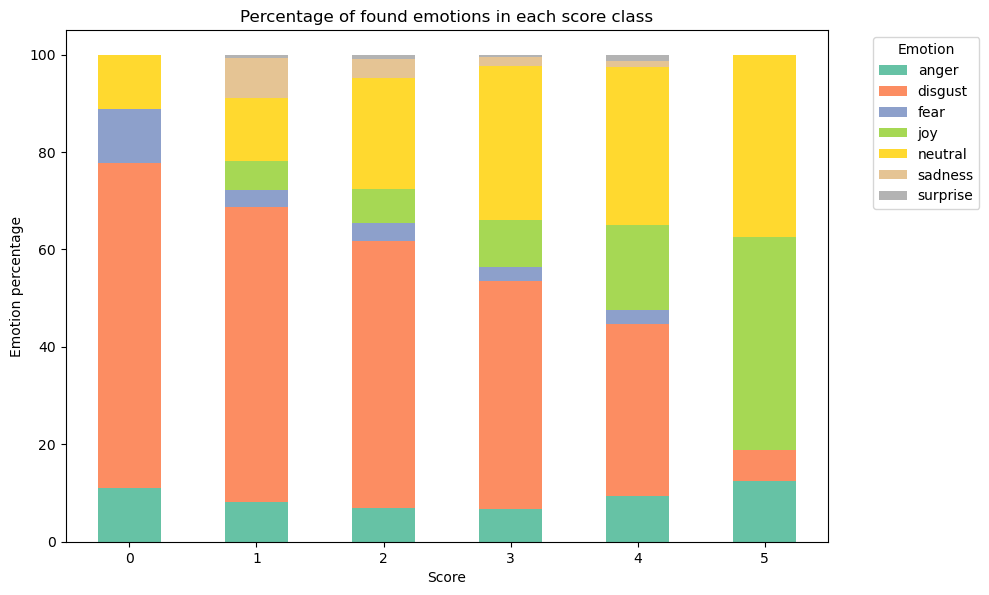

In [222]:
import scipy.stats as stats
import seaborn as sns
# Compute counts for each score and emotion
emotion_counts = emotion_data.groupby(['score'])["max_feel"].value_counts().unstack(fill_value=0)
# Then their percentage in each score class
emotion_percentages = emotion_counts.div(emotion_counts.sum(axis=1), axis=0) * 100

emotion_percentages.plot(kind='bar', stacked=True, colormap="Set2", figsize=(10, 6))
plt.title("Percentage of found emotions in each score class")
plt.xlabel("Score")
plt.ylabel("Emotion percentage")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

emotion_percentages = emotion_percentages.reset_index()



In [224]:
# Compute the spearman correlation for each emotion between its percentage and its score
spearman_results = {}
for emotion in emotion_counts.columns:
    spearman_corr, _ = stats.spearmanr(emotion_percentages['score'], emotion_percentages[emotion])
    spearman_results[emotion] = {'Spearman correlation': spearman_corr}

spearman_df = pd.DataFrame(spearman_results).T
print("Spearman correlation for emotions by score: ")
print(spearman_df)

Spearman correlation for emotions by score: 
          Spearman correlation
anger                 0.200000
disgust              -1.000000
fear                 -0.942857
joy                   1.000000
neutral               1.000000
sadness              -0.289886
surprise              0.115954


Based on above plot and statistics, there is a meaningful relationship between emotion scores and ratings. For example, fear and sadness can be used to identify negative reviews or even negative sentences.

Finally, we use "cardiffnlp/twitter-roberta-base-sentiment-latest" model to predict the sentiment/polarity of the reviews. We will show that we can use negativity scores of this model to compare negative reviews. 

In [227]:
negative_reviews = polarity_sentiment(emotion_data)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [229]:
# sorting negative reviews by their polarity
top_negative_rev = (-negative_reviews[negative_reviews["polarity"] != 0.0]["polarity"]).argsort()

In [232]:
# 5 most negative reviews according to our model
negative_reviews[negative_reviews["polarity"] != 0.0]["review"].iloc[top_negative_rev[:5]].tolist()

["What was I doing?!?!?!? It is all mike lelevier's fault. He made me drink this azz beer. I come to alaska and drink this. So sorry. Not much better than a Panama! ",
 'This is a terrible beer and should be avoided at all costs! The ginseng is so overpowering and gross that it totally kills this beer. Some things just should not be infused into beer! ',
 'oh wow, this is awful. Aroma and flavour smacks of adjuncts. Crappy vegetal, grainy flavour, blech, bad stuff.  ',
 "clear and bad. bad taste.  i'd prefer less taste.barnyard, basement aromas, rotten eggs, cough drop, skunky, ass. ",
 'not very good at all. looks nice, but tastes awful. golden in colour, big white head, horrible taste.  ']

In [233]:
# 5 most "positive" reviews (among negatives) according to our model
negative_reviews[negative_reviews["polarity"] != 0.0]["review"].iloc[top_negative_rev[-5:]].tolist()

["This is what Chinese Budweiser tastes like, except this beer does have some taste to it (it's not very good but it's there). ",
 '12oz can I brought back from Colombo pours a clear dark gold with no head. Nose has adjuncts, corn, metal, honey. Flavor is super sweet, metal, corn, honey. Sweet finish. Bad. ',
 '...bottle.  Nothiing amazing here, typical asian lager.  Watery, ricey, but good to knock out spicy foods from the palate, but otherwise, no real reason to drink it. ',
 'Gold color, at least has a decent head.  Smells like the typical piss American beer.  This one is saved by a slightly sweet taste, not completely terrible. ',
 'Bleh...  another strong corn pale lager from the far east.  This beer is best with lemon and only when eating a huge spicy meal.  Not much going on beyond the corn flavour and aroma.  It does give off a huge white foamy head on its bright golden colour.   ']

We observe a change in vocabulary used between the two lists of reviews, indicating the model is capable of finding reviews that use a more negative vocabulary (inflammatory keywords).

### Task 3 : Identifying the main criticism(s) and complaints

In this part, we want to find negative features and complaints about a beer in the reviews.
First, we will try to find some features of beer that are common in its negative reviews. We will do that with the aid of tf-idf method. Then we will use emotion analysis to find the main complaints in the reviews of high-rated beers. Finally, we will try to investigate if there is a relationship between low-rated beers and brewery/user location. 

In [ ]:
# 5 most negative reviews of a popular beer
worst_beer_reviews[next(iter(worst_beer_reviews))][:5]

['640 ml bottle @home,bb 31/05/2018.Golden,clear. Faint hay aroma.Taste is malt-ish water. Fizzy. ',
 'Clear golden color with white head. Aroma of malt, grain and hay. Taste is little sweet with light bitter finish. Notes of citrus. Normal lager beer.  ',
 '330ml bottle. Clear yellow, thinnest white cap. Nose is malt, honey, corn, grass. Flavors follow with a touch of skunk on the sweetish finish. Ok. ',
 'Bottle in pai, thailand. Common lager, could be from anywhere, refreshing, crispy. ',
 'Bottled as Tiger Asian Lager, from Total Wine, South Richmond. Pours clear pale golden with a large white head. Aroma is sweet corn and grass. Flavor is sweet grasses, grain, very bitter green leaves. Nothing Iâ\x80\x99d choose to drink again. ']

In thw following tables, We will calculate tf-idf scores for the words in both positive and negative reviews of a beer. the table is sorted by difference between tf-idf scores of positive and negative reviews. The words are more likely to be a nagative feature of a beer if their score_diff is higher.

In [ ]:
# considering both 1grams and 2grams
beer_id = next(iter(worst_beer_reviews))
corpus_best = best_beer_reviews[beer_id]
corpus_worst = worst_beer_reviews[beer_id]

print(f"top negative words for beer {beer_id} :")
top_negative_words(corpus_worst, corpus_best, use_tfidf=True, lemmatize=True, ngrams=(1, 2)).head(20)

top negative words for beer 3126 :


,avg_pos_score,avg_neg_score,score_diff
watery,0.003693,0.011865,0.008173
thin,0.005503,0.012705,0.007203
white head,0.011754,0.018465,0.006712
corn,0.006743,0.013394,0.006651
white,0.013932,0.020364,0.006432
pale,0.015450,0.020881,0.005431
weak,0.001436,0.006807,0.005371
bottle,0.015092,0.020376,0.005284
metallic,0.001603,0.006362,0.004759
head,0.018709,0.023454,0.004745


In [238]:
# considering only bigrams
print(f"top negative words for beer {beer_id} :")
top_negative_words(corpus_worst, corpus_best, use_tfidf=True, lemmatize=True, ngrams=(2, 2)).head(10)

top negative words for beer 3126 :


,avg_pos_score,avg_neg_score,score_diff
white head,0.014118,0.022053,0.007935
pale yellow,0.004154,0.009435,0.005280
taste like,0.000687,0.005375,0.004688
head aroma,0.008293,0.012070,0.003778
bottle pale,0.000000,0.003768,0.003768
not good,0.000428,0.003927,0.003500
bottle clear,0.001292,0.004476,0.003184
head taste,0.000269,0.003377,0.003108
color white,0.000652,0.003411,0.002759
thin body,0.001243,0.003823,0.002581


In [241]:
n = 10

for i, beer_id in enumerate(worst_beer_reviews):
    if i == 0:
        continue

    if i - 1 >= n:
        break

    corpus_best = best_beer_reviews[beer_id]
    corpus_worst = worst_beer_reviews[beer_id]

    negative_words = top_negative_words(corpus_worst, corpus_best, use_tfidf=True, lemmatize=True, ngrams=(1, 2))
    negative_words = list(negative_words.head(20).index)

    print(f"top negative words for beer with id = {beer_id} : {negative_words}", end="\n\n")

top negative words for beer with id = 730 : ['watery', 'no', 'bottle', 'white head', 'pale', 'head', 'water', 'white', 'yellow', 'bland', 'weak', 'thin', 'corn', 'pale yellow', 'head aroma', 'malt', 'almost', 'aroma', 'not good', 'skunk']

top negative words for beer with id = 224 : ['corn', 'watery', 'aroma', 'nothing', 'caramel', 'light', 'weak', 'malt', 'sweet', 'no', 'metallic', 'boring', 'not good', 'bottle', 'taste like', 'skunky', 'bland', 'thin', 'say', 'cardboard']

top negative words for beer with id = 225 : ['watery', 'aroma', 'yellow', 'corn', 'head', 'no', 'malt', 'white', 'pours', 'white head', 'bottle', 'nothing', 'pale', 'water', 'flavor', 'clear', 'skunky', 'little', 'small', 'grain']

top negative words for beer with id = 230 : ['water', 'no', 'watery', 'yellow', 'aroma', 'head', 'corn', 'pale', 'little', 'malt', 'bad', 'flavour', 'small', 'boring', 'bland', 'white', 'white head', 'metallic', 'faint', 'really']

top negative words for beer with id = 226 : ['corn', 'ar

We can use these features to gain insight toward users' dislikes and find negative features for each aspect of the beer like palate, aroma, appearance, etc in the next milestone. We can investigate if some bear's aspect are more prone to be disliked by users. We will apply more nlp techniques in the next phase.

In the rest of the note book we will use emotion analysis methods.
As we discussed in our prevoius task, we can use our mentioned emotion analysis model to get negative reviews even though the reviews are positive by filtering on emotions as depicted below where we are seaching for reviews that are classified as sad. We observe that the review are of course positive but still have some complaint or advice for improvement.

In [242]:
emotion_data[((emotion_data["score"] == 5) | (emotion_data["score"] == 4)) 
             & (emotion_data["max_feel"] == "sadness")]["review"].iloc[:10].tolist()

['A bit mnah mnah in aftertaste and tchup tchup roast but the khhhhhh thickness feels fnnnnnnn ',
 'from cellar at standing order ... deep red brown... thin lacing ... light meaty ... big chocolate nose ... still little green ... but good solid roast ... little chocolate ... little woody ... light hop in finish ... tk 2 dark red brown ... creamy tan head ... soft roast malts ... thin roast ... light sourness... roast malt ',
 'Bottle shared at green sheep. Hazy golden colour. Nose is citruss and zest. Taste is also citrussy, zesty, with a nice bitter finish. Sadly the aroma faded quickly. Then it was just a medium bitter ipa. ',
 'Cask, The Crown, Belfast.  Cloudy somewhat gloomy appearance, think it was brown, but hard to tell under those gas lamps...Some nice fragrant hops in the aroma, with caramel malt and nuts too. Similar themes resonated in the flavour which was surprisingly complex.  Dryish,  gently bitter finish.  Really quite good. ',
 " 500ml bottle, LOT 1010, BB Feb 2015   

In above list of reviews, we can see that these reviews are realted to the high rated beers, but they still contains some criticisms or complaints that can be used for feature exatrction.

Furthermore, we can tokenize reviews based on sentenses and find the sentence that accually is a complaint based on emotion analysis. We can use this sentence to extract features and provide some advice for improvements of the beers.

In [250]:
import re
def split_review(review):
    return re.split('\\;|\\.|\\?|\\!', review) # tokenize on sentences (by . ; ? !)

# Split each review and create a new DataFrame, keeping 'beer_name' with each review
split_data = []
for idx, row in emotion_data[((emotion_data["score"] == 5) | (emotion_data["score"] == 4))].iterrows():
    review_chunks = split_review(row['review']) 
    for chunk in review_chunks:
        split_data.append({'beer_name': row['beer_name'], 'review': chunk})

split_df = pd.DataFrame(split_data)

token_emotions = emotion_sentiment(split_df)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Below you can see some complaints for high rated beers:

In [255]:
token_emotions[(token_emotions["max_feel"] == "sadness")]["review"].iloc[:20].tolist()

[' Appearance dark with cream head',
 ' Pours slightly hazy dark golden with an off-white head',
 ' Not worth the 4',
 ' disappointing for a local',
 '[email\xa0protected]/*  */dirty hazy murky ruby with big pine pithy nose, sticky, sweet rich, heavy, pine very much an american style barley wine rather than IIPA but this is the "clean" (i',
 ' Pours dark red with no head',
 ' Opaque murky red color, averagecsized off-white head',
 ' Finishes chalky melon and a decent citrusy grape buzz on the linger',
 'Very hazy, milky golden and light ringed white head',
 ' Poor dark as hell with a not so long lasting deep brown head',
 ' Tasted on the 28/11/2016',
 ' Pours cloudy dusky pink',
 ' Body thin',
 ' 8 4 7 4 16Hazy dark brown with a fluffy dark tan head',
 'Thin light brown head on a dark shiny body',
 " It's a great base porter but man it's spicy, not an easy drinker",
 ' Appearance - hazy yellow thin head',
 ' Tasted on the 30/11/2016',
 ' great holding brown head on a dark body',
 ' Tas

We can then aggregate on specific parts of the sentence and beer name to see the parts of sentences where the complaints are described for each beer

In [268]:
beer_name = "Tiger Beer"
token_emotions[(token_emotions["max_feel"] == "sadness") & (token_emotions["beer_name"] == beer_name)]["review"].iloc[:10].tolist()

['                                                                                                                                                                                      ',
 '  Perhaps a bit lacking in depth or substance']

Finally, we can see average of ratings in different regions of the world. In the next milestone, we will investigate the effect of location more deeply to see if there is a correlation between location and rating and people from different areas have common complaints and expectations or not.

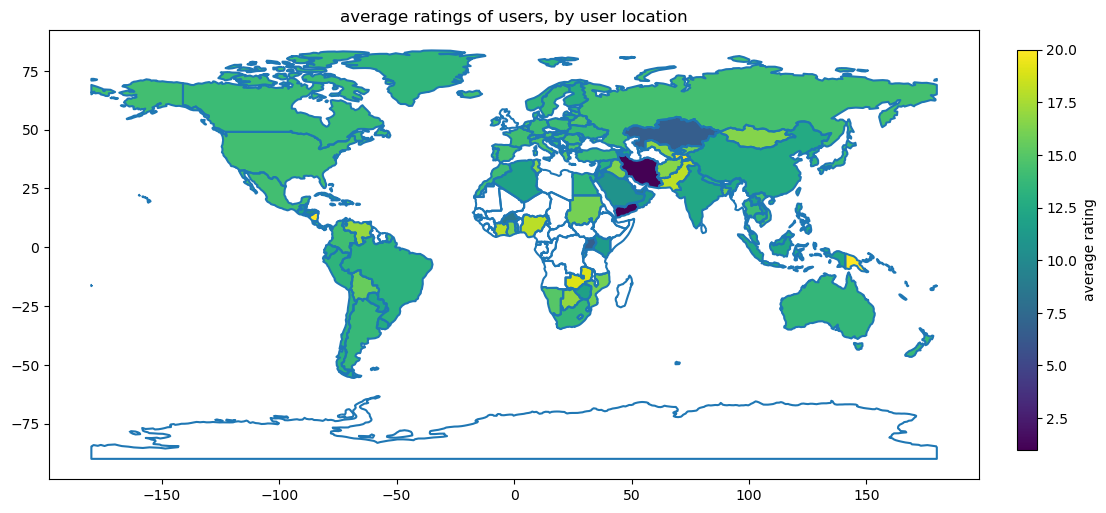

In [271]:
plot_avg_overall_map(rb_users, "average ratings of users, by user location")

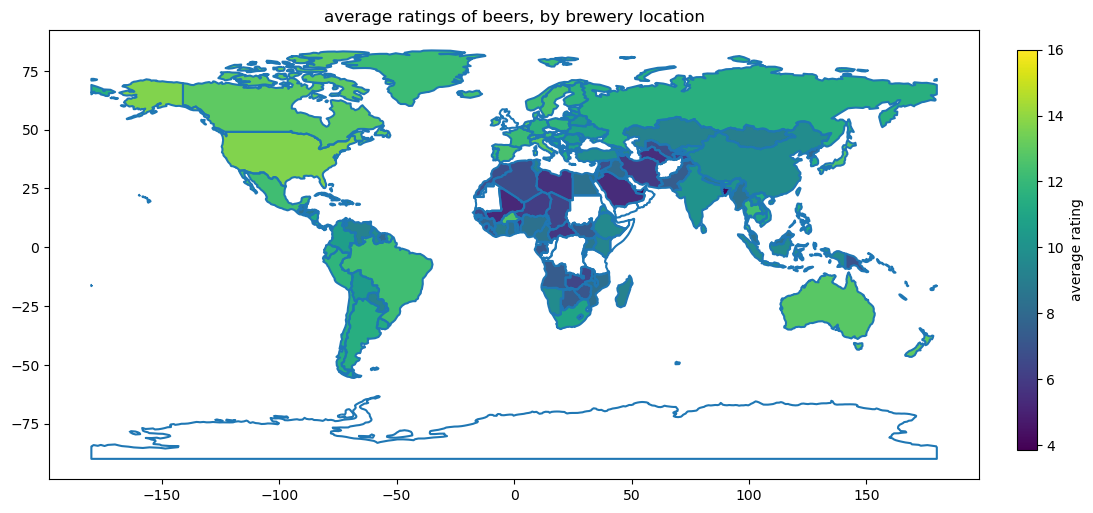

In [272]:
plot_avg_overall_map(rb_beers, "average ratings of beers, by brewery location")